# filling missing values

In [1]:
import pandas as pd

df=pd.read_csv('data/data1.csv')




In [2]:
df['date']=pd.to_datetime(df['date'])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2922 entries, 0 to 2921
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              2922 non-null   datetime64[ns]
 1   tempmax           2922 non-null   float64       
 2   tempmin           2922 non-null   float64       
 3   temp              2922 non-null   float64       
 4   dew               2922 non-null   float64       
 5   humidity          2922 non-null   float64       
 6   precip            2922 non-null   float64       
 7   precipcover       2922 non-null   float64       
 8   preciptype        2922 non-null   object        
 9   windgust          2922 non-null   float64       
 10  windspeed         2922 non-null   float64       
 11  winddir           2922 non-null   float64       
 12  sealevelpressure  2922 non-null   float64       
 13  cloudcover        2922 non-null   float64       
 14  visibility        2922 n

In [5]:
df[df['pm25'].isna()]['date'].dt.month.value_counts().sort_index()

date
1     16
2      7
3     13
4     30
5     29
6     53
7     26
8     39
9     16
10    32
11    37
12    23
Name: count, dtype: int64

In [4]:
d=5
m=2
df[(df['date'].dt.day==d) & (df['date'].dt.month==m)][['date','pm25']]

,date,pm25
35,2016-02-05,158.0
401,2017-02-05,129.0
766,2018-02-05,87.0
1131,2019-02-05,120.0
1496,2022-02-05,92.0
1861,2023-02-05,118.0
2226,2024-02-05,122.0
2592,2025-02-05,80.0


## step 1 ) using interpollalation

In [5]:
df['pm25'].isna().sum()

np.int64(321)

In [6]:
df = df.sort_values("date")
df = df.set_index("date")

In [7]:
df['aqi']=df['pm25']

In [8]:
df["aqi_source"] = "original"
df.loc[df["aqi"].isna(), "aqi_source"] = None


In [9]:
df["aqi_interp"] = df["aqi"].interpolate(
    method="time",
    limit=2,
    limit_direction="both"
)


In [10]:
mask = df["aqi"].isna() & df["aqi_interp"].notna()

df.loc[mask, "aqi"] = df.loc[mask, "aqi_interp"]
df.loc[mask, "aqi_source"] = "BTM_temporal_interp"


In [11]:
df = df.drop(columns=["aqi_interp"])
df = df.reset_index()



In [12]:
df["aqi"].isna().sum()

np.int64(158)

In [13]:

df["aqi_source"].value_counts()


aqi_source
original               2601
BTM_temporal_interp     163
Name: count, dtype: int64

In [14]:
163+158

321

In [15]:
df.head(3)

,date,tempmax,tempmin,temp,dew,humidity,precip,precipcover,preciptype,windgust,...,uvindex,sunrise,sunset,moonphase,conditions,description,icon,pm25,aqi,aqi_source
0,2016-01-01,28.1,16.1,21.1,13.9,67.7,0.0,0.0,no rain,41.8,...,8,2016-01-01 06:41:30,2016-01-01 18:04:12,0.72,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,NaN,107.0,BTM_temporal_interp
1,2016-01-02,28.1,14.1,21.4,10.4,54.1,0.0,0.0,no rain,37.8,...,9,2016-01-02 06:41:53,2016-01-02 18:04:46,0.75,Clear,Clear conditions throughout the day.,clear-day,NaN,107.0,BTM_temporal_interp
2,2016-01-03,27.3,15.0,21.1,11.8,60.3,0.0,0.0,no rain,37.1,...,9,2016-01-03 06:42:15,2016-01-03 18:05:19,0.78,Clear,Clear conditions throughout the day.,clear-day,107.0,107.0,original


# level 2 agragte of selected city avgs

In [17]:
# find out nearest station
BTM_LAT = 12.9135218
BTM_LON = 77.5950804
stations = [
    {"station": "Jayanagar 5th Block", "lat": 12.920984, "lon": 77.584908},
    {"station": "bwssb", "lat": 12.93890556, "lon": 77.69727222},
    {"station": "Bapuji Nagar", "lat": 12.951913, "lon": 77.539784},
    {"station": "Hebbal", "lat": 13.029152, "lon": 77.585901},
    {"station": "Hombegowda Nagar", "lat": 12.938539, "lon": 77.5901},
    {"station": "Silk Board", "lat": 12.917348, "lon": 77.622813},
    {"station": "BTM", "lat": 12.9135218, "lon": 77.5950804},    
    {"station": "Peenya", "lat": 13.0270199, "lon": 77.494094},
    {"station": "City Railway Station", "lat": 12.9756843, "lon": 77.5660749},
    {"station": "SaneguravaHalli", "lat": 12.990328, "lon": 77.5431385},
    {"station": "Kadabesanahalli", "lat": 12.9352049, "lon": 77.6814488},
]

from math import radians, sin, cos, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers

    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return R * c


In [18]:
for s in stations:
    s["distance_km"] = haversine(
        BTM_LAT, BTM_LON,
        s["lat"], s["lon"]
    )

stations_sorted = sorted(stations, key=lambda x: x["distance_km"])
for s in stations_sorted:
    print(f"{s['station']:25s} -> {s['distance_km']:.2f} km")



BTM                       -> 0.00 km
Jayanagar 5th Block       -> 1.38 km
Hombegowda Nagar          -> 2.83 km
Silk Board                -> 3.04 km
Bapuji Nagar              -> 7.36 km
City Railway Station      -> 7.59 km
Kadabesanahalli           -> 9.67 km
SaneguravaHalli           -> 10.23 km
bwssb                     -> 11.43 km
Hebbal                    -> 12.90 km
Peenya                    -> 16.70 km


In [19]:

import glob
import os

dfs = []

for file in glob.glob("data_aqi_city/*.csv"):
    df_city = pd.read_csv(file)

    # store city name (from file name)
    city_name = os.path.basename(file).replace(".csv", "")
    df_city["city"] = city_name

    dfs.append(df_city)



In [21]:
import pandas as pd

corrs = []
mads = []
cities = []
overlap_days = []

# Ensure BTM date is datetime
df["date"] = pd.to_datetime(df["date"], errors="coerce")
btm = df.set_index("date")["pm25"]

for fill1 in dfs:

    # --- Clean city data ---
    fill1["date"] = pd.to_datetime(fill1["date"], errors="coerce")
    fill1 = fill1[["date", " pm25", "city"]]

    # Remove unwanted years
    fill1 = fill1[~fill1["date"].dt.year.isin([2020, 2021])]

    # Convert AQI safely
    fill1[" pm25"] = pd.to_numeric(fill1[" pm25"], errors="coerce")

    city_name = fill1["city"].iloc[0]

    city_series = fill1.set_index("date")[" pm25"]

    # --- TRUE overlap only ---
    common = pd.concat(
        [btm.rename("btm"), city_series.rename("city")],
        axis=1
    ).dropna()

    n = len(common)

    if n < 30:  # not enough data
        corr = None
        mad = None
        rec = "No"
    else:
        corr = common["btm"].corr(common["city"])
        mad = (common["btm"] - common["city"]).abs().mean()
        rec = "Yes" if (corr >= 0.5 and mad <= 30) else "No"

    # Store results
    cities.append(city_name)
    corrs.append(corr)
    mads.append(mad)
    overlap_days.append(n)

    
summary_df = pd.DataFrame({
    "city": cities,
    "correlation": corrs,
    "mad": mads,
    "overlap_days": overlap_days,
    "recommended": [
        "Yes" if (c is not None and c >= 0.5 and m is not None and m <= 30)
        else "No"
        for c, m in zip(corrs, mads)
    ]
})

summary_df.sort_values(
    by=["recommended", "correlation", "mad"],
    ascending=[False, False, True]
)


,city,correlation,mad,overlap_days,recommended
1,btm,1.000000,0.000000,2601,Yes
3,bwsssbk,0.545147,28.572590,861,Yes
5,hombegowda,0.507010,26.767486,1587,Yes
9,silkboard,0.442963,25.160891,1616,No
6,jayanagar,0.440701,28.444791,1603,No
2,bwssb,0.432136,29.051527,1048,No
7,peenya,0.411883,28.774251,2237,No
0,bapujinagar,0.394878,29.482736,1535,No
4,hebbal,0.394083,29.910607,1499,No
8,saneguravahalli,NaN,NaN,6,No


In [25]:
# Ensure date index
df["date"] = pd.to_datetime(df["date"])
df = df.set_index("date")

print("AQI missing before:", df["aqi"].isna().sum())


AQI missing before: 158


In [26]:
donor_cities = ['bwsssbk', 'hombegowda', 'silkboard', 'jayanagar']

weights = (
    summary_df
    .set_index("city")
    .loc[donor_cities, "mad"]
)

weights = 1 / weights
weights


city
bwsssbk       0.034999
hombegowda    0.037359
silkboard     0.039744
jayanagar     0.035156
Name: mad, dtype: float64

In [27]:
donor_series = []

for fill1 in dfs:
    city = fill1["city"].iloc[0]

    if city not in donor_cities:
        continue

    fill1["date"] = pd.to_datetime(fill1["date"], errors="coerce")
    fill1[" pm25"] = pd.to_numeric(fill1[" pm25"], errors="coerce")

    s = (
        fill1
        .set_index("date")[" pm25"]
        .rename(city)
    )

    donor_series.append(s)

donor_df = pd.concat(donor_series, axis=1)
donor_df.head()


,bwsssbk,hombegowda,jayanagar,silkboard
date,,,,
2015-12-29,NaN,NaN,NaN,NaN
2015-12-30,132.0,NaN,NaN,NaN
2015-12-31,170.0,NaN,NaN,NaN
2016-01-02,NaN,NaN,NaN,NaN
2016-01-03,127.0,NaN,NaN,NaN


In [28]:
df_filled = df.copy()

missing_dates = df_filled[df_filled["aqi"].isna()].index

for d in missing_dates:
    if d not in donor_df.index:
        continue

    values = donor_df.loc[d].dropna()

    if len(values) == 0:
        continue

    w = weights.loc[values.index]

    df_filled.loc[d, "aqi"] = (values * w).sum() / w.sum()


In [29]:
print("AQI missing after:", df_filled["aqi"].isna().sum())


AQI missing after: 45


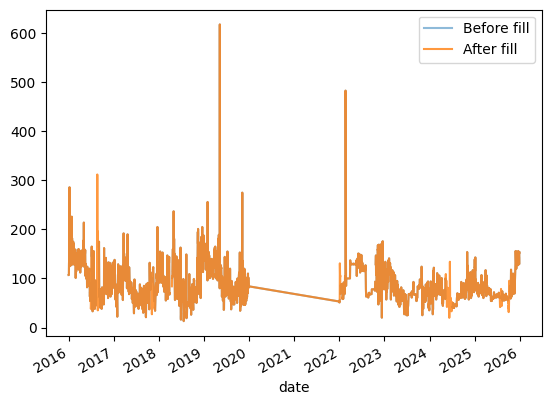

In [33]:
import matplotlib.pyplot as plt
df["aqi"].plot(label="Before fill", alpha=0.5)
df_filled["aqi"].plot(label="After fill", alpha=0.8)
plt.legend()


In [34]:
# final changes to df

# 1. Identify rows where AQI is missing
mask = df['aqi'].isna() & df_filled['aqi'].notna()

# 2. Fill AQI only where missing
df.loc[mask, 'aqi'] = df_filled.loc[mask, 'aqi']

# 3. Update AQI source ONLY for filled values
df.loc[mask, 'aqi_source'] = 'aggregated_nearby_stations'


In [ ]:

df['aqi'].isna().sum()

np.int64(45)

In [38]:
df['aqi_source'].value_counts()

aqi_source
original                      2601
BTM_temporal_interp            163
aggregated_nearby_stations     113
Name: count, dtype: int64

In [39]:
163+113+45

321

## level 3) filled using sesanality

In [41]:
df[df['aqi'].isna()].index.year.value_counts()


date
2016    21
2018    16
2022     3
2017     2
2023     2
2025     1
Name: count, dtype: int64

In [62]:
df.index.year.value_counts()

date
2016    366
2024    366
2018    365
2017    365
2019    365
2022    365
2023    365
2025    365
Name: count, dtype: int64

In [63]:
# from collections import defaultdict

# df['year'] = df.index.year
# leap_years=[2016,2020,2024]
# doy_values = defaultdict(list)
# df = df.sort_index()
# df['doy'] = df.index.dayofyear

# for i in range(len(df)):
#     d=df.iloc[i]['doy']
#     val=df.iloc[i]['pm25']
#     year=df.iloc[i]['year']
#     if pd.notna(val):
#         if(d==1):
#             doy_values[1].append(val)
#             doy_values[2].append(val)
#             if(year!=2016):
#                 if((year-1) in leap_years):
#                     doy_values[366].append(val)
#                 else:
#                     doy_values[365].append(val)
            
#         elif(d==365):
#             doy_values[365].append(val)
#             doy_values[364].append(val)
#             if(year!=2025):
#                 if((year) in leap_years):
#                     doy_values[366].append(val)
#                 else:
#                     doy_values[1].append(val)
            
#         elif(d==366):
#             doy_values[366].append(val)
#             doy_values[365].append(val)
#             if(year!=2025):
#                 doy_values[1].append(val)

#         else:
#             doy_values[d].append(val)
#             doy_values[d-1].append(val)
#             doy_values[d+1].append(val)

            
            

In [75]:
def climo_doy(idx):
    doy = idx.dayofyear
    if idx.is_leap_year and doy > 59:
        return doy - 1
    return doy

df = df.sort_index()
df['climo_doy'] = df.index.map(climo_doy)


In [76]:
len(df['climo_doy'].unique())

365

In [77]:
from collections import defaultdict

doy_values = defaultdict(list)

for d, val in zip(df['climo_doy'], df['aqi']):
    if pd.notna(val):
        doy_values[d].append(val)


In [78]:
len(doy_values[1])

8

In [79]:
len(doy_values)

365

In [80]:
climo_pm1_mean = {}

for d in range(1, 366):
    neighbors = [
        365 if d == 1 else d - 1,
        d,
        1 if d == 365 else d + 1
    ]

    vals = []
    for k in neighbors:
        vals.extend(doy_values.get(k, []))

    if vals:
        climo_pm1_mean[d] = sum(vals) / len(vals)


In [81]:
climo_pm1_mean

{1: 98.2861825218181,
 2: 96.39814814814815,
 3: 98.94444444444446,
 4: 107.35550835410525,
 5: 115.98190569611235,
 6: 120.61937674946911,
 7: 126.76125752907508,
 8: 121.44041574262349,
 9: 115.81683357815564,
 10: 107.63888888888887,
 11: 107.37685185185184,
 12: 105.28333333333332,
 13: 100.06666666666668,
 14: 95.89166666666667,
 15: 97.84166666666665,
 16: 100.43333333333334,
 17: 102.125,
 18: 100.54166666666667,
 19: 99.0,
 20: 97.875,
 21: 99.20833333333333,
 22: 101.16666666666667,
 23: 100.95833333333333,
 24: 97.08333333333333,
 25: 94.33333333333333,
 26: 91.875,
 27: 92.79166666666667,
 28: 90.33333333333333,
 29: 98.08333333333333,
 30: 101.5,
 31: 105.75,
 32: 103.45833333333333,
 33: 102.75,
 34: 101.375,
 35: 104.125,
 36: 105.83333333333333,
 37: 109.45833333333333,
 38: 107.54166666666667,
 39: 107.91666666666667,
 40: 106.16666666666667,
 41: 105.16666666666667,
 42: 103.16666666666667,
 43: 103.15277777777779,
 44: 101.04166666666667,
 45: 99.33333333333333,
 46: 

In [82]:
mask = df['aqi'].isna()

df.loc[mask, 'aqi'] = df.loc[mask, 'climo_doy'].map(climo_pm1_mean)
df.loc[mask, 'aqi_source'] = 'climatology_pm1_365'


In [83]:
df['aqi'].isna().sum()

np.int64(0)

In [84]:
df['aqi_source'].value_counts()

aqi_source
original                      2601
BTM_temporal_interp            163
aggregated_nearby_stations     113
climatology_pm1_365             45
Name: count, dtype: int64

In [85]:
163+113+45


321

### saving file back

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2922 entries, 2016-01-01 to 2025-12-31
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tempmax           2922 non-null   float64
 1   tempmin           2922 non-null   float64
 2   temp              2922 non-null   float64
 3   dew               2922 non-null   float64
 4   humidity          2922 non-null   float64
 5   precip            2922 non-null   float64
 6   precipcover       2922 non-null   float64
 7   preciptype        2922 non-null   object 
 8   windgust          2922 non-null   float64
 9   windspeed         2922 non-null   float64
 10  winddir           2922 non-null   float64
 11  sealevelpressure  2922 non-null   float64
 12  cloudcover        2922 non-null   float64
 13  visibility        2922 non-null   float64
 14  solarradiation    2922 non-null   float64
 15  solarenergy       2922 non-null   float64
 16  uvindex           2922 n

In [87]:
df=df.drop(['doy','year','is_leap','climo_doy'],axis=1)

In [88]:
df = df.reset_index()


In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2922 entries, 0 to 2921
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              2922 non-null   datetime64[ns]
 1   tempmax           2922 non-null   float64       
 2   tempmin           2922 non-null   float64       
 3   temp              2922 non-null   float64       
 4   dew               2922 non-null   float64       
 5   humidity          2922 non-null   float64       
 6   precip            2922 non-null   float64       
 7   precipcover       2922 non-null   float64       
 8   preciptype        2922 non-null   object        
 9   windgust          2922 non-null   float64       
 10  windspeed         2922 non-null   float64       
 11  winddir           2922 non-null   float64       
 12  sealevelpressure  2922 non-null   float64       
 13  cloudcover        2922 non-null   float64       
 14  visibility        2922 n

In [90]:
df = df.sort_values('date')
df['date'] = pd.to_datetime(df['date'])


In [91]:
df.to_csv("data/data2_nafilled.csv", index=False)
